# SRL with Logistic Regression

This is a simple implementation of SRL with Logistic Regression, using a sparse feature vector. The dataset implemented for this experiment is the [English CoNLL-U (Universal Dependencies Consortium)](https://github.com/UniversalPropositions/UP-1.0/tree/master/UP_English-EWT) from the 1.0 version of the Universal Proposition Banks (Universal Propositions Consortium). 

Three features are used:
- A feature combining the directed dependency path between the token and the predicate, along with the predicate's lemma. This feature is a string that concatenates the dependency path and the predicate lemma.
- The token's lemma as a string.
- The token's position relative to the predicate as a string. Encoded as `Before` or `After`.

The [sci-kit learn library](https://scikit-learn.org/stable/) is used for the feature vectorization and logistic regression model.


In [1]:
import json
import sys
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

sys.path.append('feature_extraction')
from extract_position_rel2pred import extract_word_position_related_to_predicate
from extract_dependency_path import extract_dependency_path
from extract_predicate import extract_predicate_lemma

### Step 1: Preprocess the data

#### Step 1.1: Load the datasets

The data is loaded from files wihin this repository. The files are in CoNNL-U Plus format.

In [2]:
dev_file_path = 'data/en_ewt-up-dev.conllu'
train_file_path = 'data/en_ewt-up-train.conllu'
test_file_path = 'data/en_ewt-up-test.conllu'


#### Step 1.2: Create a helper function to preprocess the data

The preprocessing of the data involves parsing the CoNNL-U Plus files and creating a list of lists of objects. Each list of objects represents one one proposition in a sentence. Each object represents a token in the sentence.

This process involves an expansion of the data, since one sentence can contain multiple predicate-argument structures.

Furthermore, argument labels `V` and `C-V` are both replaced with `_` since they are not to be predicted.



In [3]:
def preprocess_data(file_path):
	"""
	Parses a CoNNL-U Plus file and returns a list of objects. 
 
 	Each object represents one semantic 'frame' in a sentence. 
  	Each frame has a predicate and a list of arguments.

	data (str): The file path to the data to be preprocessed.
	"""

	sentences = [] # Initialize an empty list for all sentences.
	sentence = []  # Initialize an empty list for the current sentence.
	with open(file_path, 'r', encoding="utf8") as file:
		for line in file:
			line = line.strip().split('\t')
			if line[0].startswith('#'):
				# If the line starts with '#', it's a comment, ignore it.
				continue
			elif line[0].strip() != '':
				# Split the features string into a dictionary.
				features = dict()
				for feature in line[5].split('|'):
					key_value_pair = feature.split('=')

					# Check if the split result is valid, if it is, add it to the dictionary.
					if len(key_value_pair) == 2:
						key, value = key_value_pair
						features[key] = value

				# Create a token if its ID does not contain a period.
				if '.' not in line[0] and len(line) > 10:
					token = {
						'id': line[0],
						'form': line[1],
						'lemma': line[2],
						'upos': line[3],
						'xpos': line[4],
						'features': features,
						'head': line[6],
						'dependency_relation': line[7],
						'dependency_graph': line[8],
						'miscellaneous': line[9],
						'predicate': line[10],
						'argument': line[11:]  # Store all remaining elements as arguments.
					}
					# Append the token to the sentence.
					sentence.append(token)

			# A new line indicates the end of a sentence.
			elif line[0].strip() == '':
				# Append the completed sentence to the sentences list.
				sentences.append(sentence)
				# Reset sentence for the next sentence.
				sentence = []

	# Iterate over all sentences. Create copies of sentences for each predicate.
	expanded_sentences = []
	for sentence in sentences:
		# Find all predicates in the sentence.
		predicates = [token['predicate'] for token in sentence if token['predicate'] != '_']

		# for every predicate, create a copy of the sentence.
		for index, predicate in enumerate(predicates):
			sentence_copy = [token.copy() for token in sentence]
			for token in sentence_copy:
				# Keep only this predicate.
				if token['predicate'] != predicate:
					token['predicate'] = '_'

				# Keep only the relevant argument for this predicate. Overwrite 'V' and 'C-V' with '_'.
				token['argument'] = '_' if token['argument'][index] in ['V', 'C-V'] else token['argument'][index]

			# Append only sentences with arguments.
			if any(token['argument'] != '_' for token in sentence_copy):	
				expanded_sentences.append(sentence_copy)

	return expanded_sentences

#### Step 1.3: Preprocess the data

Use the helper function to preprocess the data. The data is stored in a list of lists of objects:

- Each list of objects represents one proposition.
- Each object represents one token.


In [4]:
dev_data = preprocess_data(dev_file_path)
train_data = preprocess_data(train_file_path)
test_data = preprocess_data(test_file_path)

Inspect the parse of the first sentence from the training data. 

In [5]:
print(json.dumps(train_data[:1], indent=2))

[
  [
    {
      "id": "1",
      "form": "Al",
      "lemma": "Al",
      "upos": "PROPN",
      "xpos": "NNP",
      "features": {
        "Number": "Sing"
      },
      "head": "0",
      "dependency_relation": "root",
      "dependency_graph": "0:root",
      "miscellaneous": "SpaceAfter=No",
      "predicate": "_",
      "argument": "_"
    },
    {
      "id": "2",
      "form": "-",
      "lemma": "-",
      "upos": "PUNCT",
      "xpos": "HYPH",
      "features": {},
      "head": "1",
      "dependency_relation": "punct",
      "dependency_graph": "1:punct",
      "miscellaneous": "SpaceAfter=No",
      "predicate": "_",
      "argument": "_"
    },
    {
      "id": "3",
      "form": "Zaman",
      "lemma": "Zaman",
      "upos": "PROPN",
      "xpos": "NNP",
      "features": {
        "Number": "Sing"
      },
      "head": "1",
      "dependency_relation": "flat",
      "dependency_graph": "1:flat",
      "miscellaneous": "_",
      "predicate": "_",
      "argument": "

### Step 2: Extract features

#### Step 2.1: Create a helper function to extract features

The extracted features are:
- A feature combining the directed dependency path between the token and the predicate, along with the predicate's lemma. This feature is a string that concatenates the dependency path and the predicate lemma.
- The token's lemma as a string.
- The token's position relative to the predicate as a string. Encoded as `Before` or `After`.

All three strings will later be vectorized using a `DictVectorizer`, resulting in one-hot encoded features.

In [6]:
def extract_features(data):
	"""
	Extract features from the data.

	Returns a list of samples.
	"""

	samples = []

	for sentence in data:

		# Extract features
		positions_rel2pred = extract_word_position_related_to_predicate(sentence)
		d_paths = extract_dependency_path(sentence)
		predicate_lemmas = extract_predicate_lemma(sentence)
  
		# Create a sample for each token in the sentence.
		for i, token in enumerate(sentence):
			# Skip predicate tokens.	
			if token['predicate'] == '_':
				sample = {
					'lemma': token['lemma'],
					'position_rel2pred': positions_rel2pred[i],
					'dep_path+lemma': d_paths[i] + predicate_lemmas[i]
				}
				samples.append(sample)

	return samples

Use the helper function to extract features from the data.

The result is a list of samples, where each sample represents a token.Every sample is a dictionary of the three extracted features.

In [7]:
samples_train = extract_features(train_data)
samples_dev = extract_features(dev_data)
samples_test = extract_features(test_data)

#### Step 2.2 Extract the gold labels

Create a helper function to extract the gold labels from the data.

In [8]:
def extract_gold_labels(data):
    '''
    Extract gold labels.
    Return a list of gold labels.
    
    :param data_file: a list of objects, where each object represents one 'frame' in a sentence.
    '''
    labels = []
    
    for sentence in data:
        for word in sentence:
            # Skip predicate tokens.
            if word['predicate'] == '_':
                # Append the gold label to the list.
                gold_label = word['argument']
                labels.append(gold_label)

    return labels

Use the helper function to extract the gold labels from the three datasets.

In [9]:
gold_labels_train = extract_gold_labels(train_data)
gold_labels_dev = extract_gold_labels(dev_data)
gold_labels_test = extract_gold_labels(test_data)

Inspect the first ten samples and their gold labels.

In [10]:
for gold, sample in zip(gold_labels_train[:10], samples_train[:10]):
    print(f"gold: {gold:<6} sample: {sample}")

gold: _      sample: {'lemma': 'Al', 'position_rel2pred': 'Before', 'dep_path+lemma': '(down)==parataxis:kill'}
gold: _      sample: {'lemma': '-', 'position_rel2pred': 'Before', 'dep_path+lemma': '(up)==punct=>(down)==parataxis:kill'}
gold: _      sample: {'lemma': 'Zaman', 'position_rel2pred': 'Before', 'dep_path+lemma': '(up)==flat=>(down)==parataxis:kill'}
gold: _      sample: {'lemma': ':', 'position_rel2pred': 'Before', 'dep_path+lemma': '(up)==punct=>(down)==parataxis:kill'}
gold: _      sample: {'lemma': 'american', 'position_rel2pred': 'Before', 'dep_path+lemma': '(up)==amod=>(up)==nsubj:kill'}
gold: ARG0   sample: {'lemma': 'force', 'position_rel2pred': 'Before', 'dep_path+lemma': '(up)==nsubj:kill'}
gold: ARG1   sample: {'lemma': 'Shaikh', 'position_rel2pred': 'After', 'dep_path+lemma': '(up)==obj:kill'}
gold: _      sample: {'lemma': 'Abdullah', 'position_rel2pred': 'After', 'dep_path+lemma': '(up)==flat=>(up)==obj:kill'}
gold: _      sample: {'lemma': 'al', 'position_rel2p

#### Step 2.2: Save the samples

Create helper functions to save and load the samples, to skip the preprocessing and feature extraction steps during subsequent runs.

In [11]:
def save_data(data, file_path):
	with open(file_path.replace('.conllu', '.preprocessed.pkl'), 'wb') as pickle_file:
		pickle.dump(data, pickle_file)

def load_data(file_path):
	with open(file_path.replace('.conllu', '.preprocessed.pkl'), 'rb') as pickle_file:
		return pickle.load(pickle_file)

Store the samples to files. 

The files are stored in the same directory as the CoNNL-U Plus files and have a `.preprocessed.pkl` extension.


In [12]:
save_data(samples_train, train_file_path)
save_data(samples_dev, dev_file_path)
save_data(samples_test, test_file_path)

To skip the feature extraction step, load the preprocessed data from the files.

In [13]:
samples_train = load_data(train_file_path)
samples_dev = load_data(dev_file_path)
samples_test = load_data(test_file_path)

### Step 3: Train a model


Use the sci-kit learn library to instantiate a `DictVectorizer` and transform all samples into sparse feature vectors.

In [14]:
# Create a vectorizer and fit it to the samples
vectorizer = DictVectorizer()
vectorizer.fit(samples_train)

# Transform the train, dev and test samples using the vectorizer
feature_vectors_train = vectorizer.transform(samples_train)
feature_vectors_dev = vectorizer.transform(samples_dev)
feature_vectors_test = vectorizer.transform(samples_test)

Train a logistic regression model on the feature vectors and gold labels of the training data.

In [15]:
# Train a logistic regression model using the Sci-kit learn library. It defaults to multi-class classification.
model = LogisticRegression(solver='saga')
model.fit(feature_vectors_train, gold_labels_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='saga')

## Step 4: Infer and evaluate the model

Infer the gold labels for the development data. Store the predictions in a list.

In [16]:
predictions_dev = model.predict(feature_vectors_dev)

### Step 4.1: Evaluate the model

Create a helper function to create the classification report using the scikit-learn library.

In [17]:


def create_classification_report(gold_labels, predictions, label_set):
    """
    Create a classification report.
    
    :param gold_labels: The gold labels.
    :param predictions: The predictions.
    :param label_set: The set of labels.
    """

    # Create a classification report and confusion matrix
    report_dict = classification_report(gold_labels, predictions, digits=3, target_names=label_set, output_dict=True)
    report = classification_report(gold_labels, predictions, digits=3, target_names=label_set, zero_division=0.0)

    # Print the classification report.
    print(report)

    return report_dict, report, label_set

Create a helper function to create a confusion matrix using the scikit-learn library.

In [18]:
def plot_confusion_matrix(gold_labels, predictions, label_set):
    """
    Plot the confusion matrix.
    
    :param gold_labels: The gold labels.
    :param predictions: The predictions.
    :param label_set: The set of labels.
    """
    # Create a confusion matrix.
    cf_matrix = confusion_matrix(gold_labels, predictions) 

    # Create a display for the confusion matrix.
    display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label_set)

    # Create a plot for the confusion matrix.
    fig, ax = plt.subplots(figsize=(15, 15)) 

    # Display the confusion matrix.
    display.plot(ax=ax) 
    plt.xticks(rotation=90)
    plt.show() 
    
    return cf_matrix

Use the helper functions to create the classification report and confusion matrix.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

        ARG0      0.875     0.580     0.697      1733
        ARG1      0.856     0.656     0.743      3322
        ARG2      0.797     0.667     0.727      1212
        ARG3      0.543     0.247     0.339        77
        ARG4      0.537     0.617     0.574        47
        ARG5      0.000     0.000     0.000         1
    ARGM-ADJ      0.826     0.305     0.446       249
    ARGM-ADV      0.604     0.273     0.376       479
    ARGM-CAU      0.533     0.114     0.188        70
    ARGM-COM      0.000     0.000     0.000        14
    ARGM-CXN      0.000     0.000     0.000        14
    ARGM-DIR      0.500     0.271     0.351        48
    ARGM-DIS      0.865     0.344     0.492       186
    ARGM-EXT      0.886     0.345     0.497       113
    ARGM-GOL      0.000     0.000     0.000        26
    ARGM-LOC      0.649     0.207     0.313       242
    ARGM-LVB      0.935     0.387     0.547        75
    ARGM-MNR      0.820    

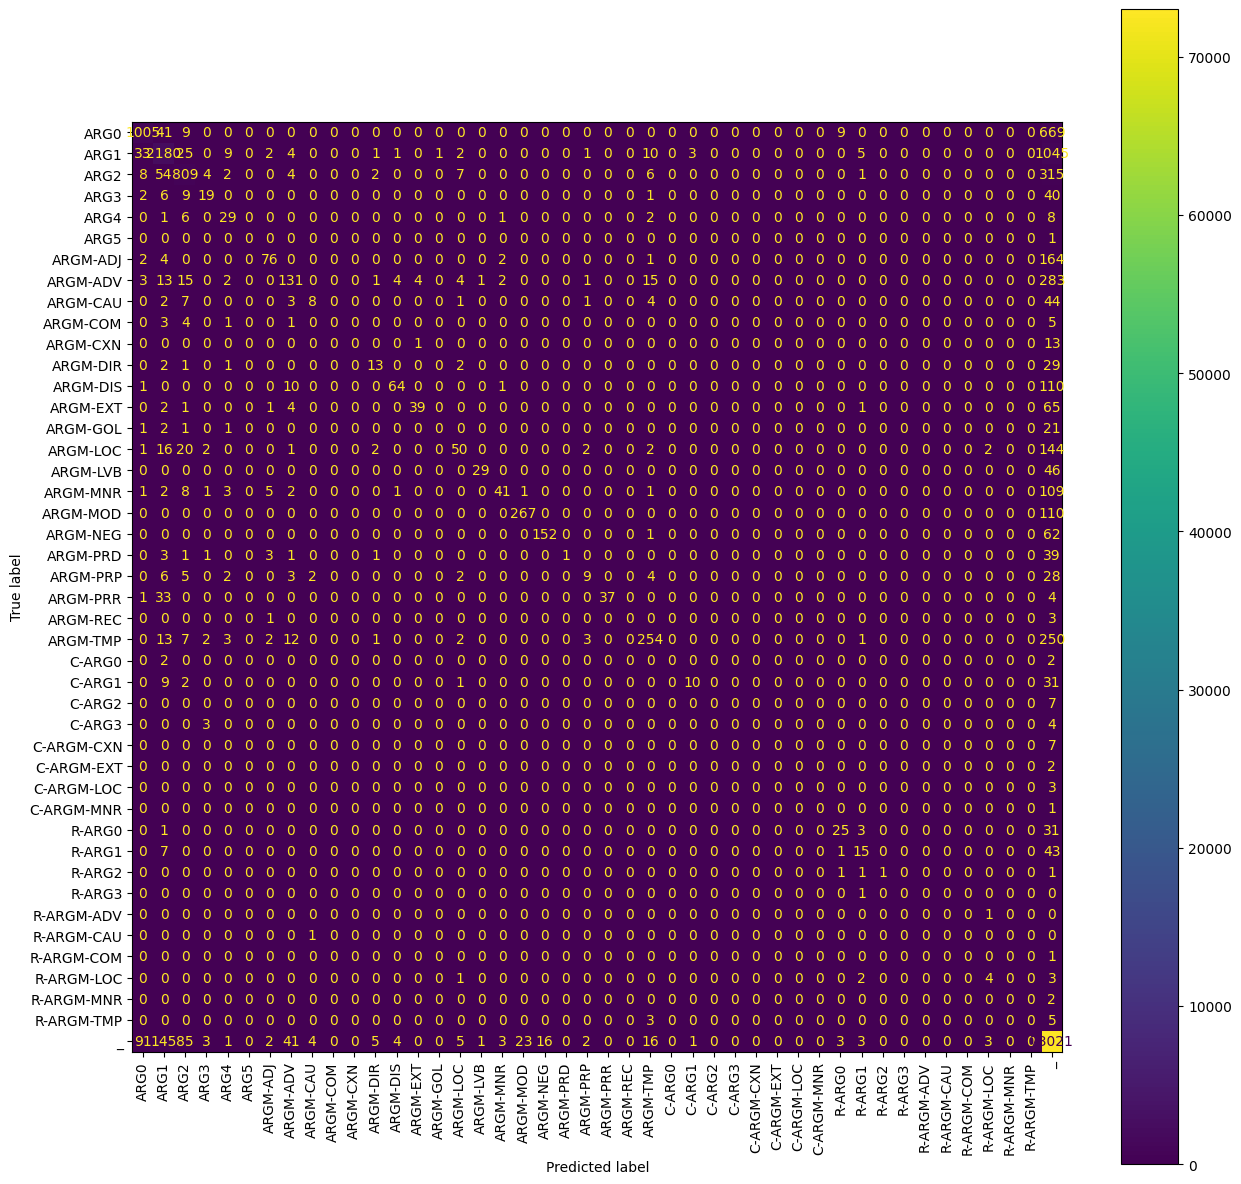

In [19]:
# Create a set of labels in alphabetical order.
label_set_dev = sorted(set(gold_labels_dev))

# Create a classification report and confusion matrix
report_dict_dev, report_dev, label_set_dev = create_classification_report(gold_labels_dev, predictions_dev, label_set_dev)
cf_matrix_dev = plot_confusion_matrix(gold_labels_dev, predictions_dev, label_set_dev)

Create a helper function to save the evaluation report to a JSON file.

In [20]:
def save_evaluation_report(report_dict, cf_matrix):
    """
    Save the evaluation report to a JSON file.
    
    :param report_dict: The classification report dictionary.
    :param cf_matrix: The confusion matrix.
    """
    evaluation_report = {
        "classification_report": report_dict,
        "confusion_matrix": cf_matrix.tolist()
    }

    # Create a report file with the current date and time
    filename = f"evaluation_report_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.json"  # create file name with current date and time

    with open(filename, 'w') as f:  # write report to file
        json.dump(evaluation_report, f, indent=4)

    print(f"Evaluation report saved to: {filename}")

Save the evaluation report of the development data to a JSON file.

In [21]:
save_evaluation_report(report_dict_dev, cf_matrix_dev)

Evaluation report saved to: evaluation_report_2024-10-10_11-55-53.json


## Step 5: Evaluate the model on the test data

Infer the gold labels for the test data.

In [22]:
# Predict the gold labels
predictions_test = model.predict(feature_vectors_test)

Evaluate the model on the test data.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

        ARG0      0.885     0.609     0.721      1733
        ARG1      0.860     0.684     0.762      3241
    ARG1-DSP      0.000     0.000     0.000         4
        ARG2      0.800     0.669     0.728      1129
        ARG3      0.649     0.324     0.432        74
        ARG4      0.463     0.554     0.504        56
        ARG5      0.000     0.000     0.000         1
        ARGA      0.000     0.000     0.000         2
    ARGM-ADJ      0.821     0.405     0.543       227
    ARGM-ADV      0.567     0.275     0.370       495
    ARGM-CAU      0.500     0.174     0.258        46
    ARGM-COM      0.000     0.000     0.000        13
    ARGM-CXN      1.000     0.083     0.154        12
    ARGM-DIR      0.500     0.213     0.299        47
    ARGM-DIS      0.821     0.352     0.492       182
    ARGM-EXT      0.913     0.400     0.556       105
    ARGM-GOL      0.000     0.000     0.000        24
    ARGM-LOC      0.667    

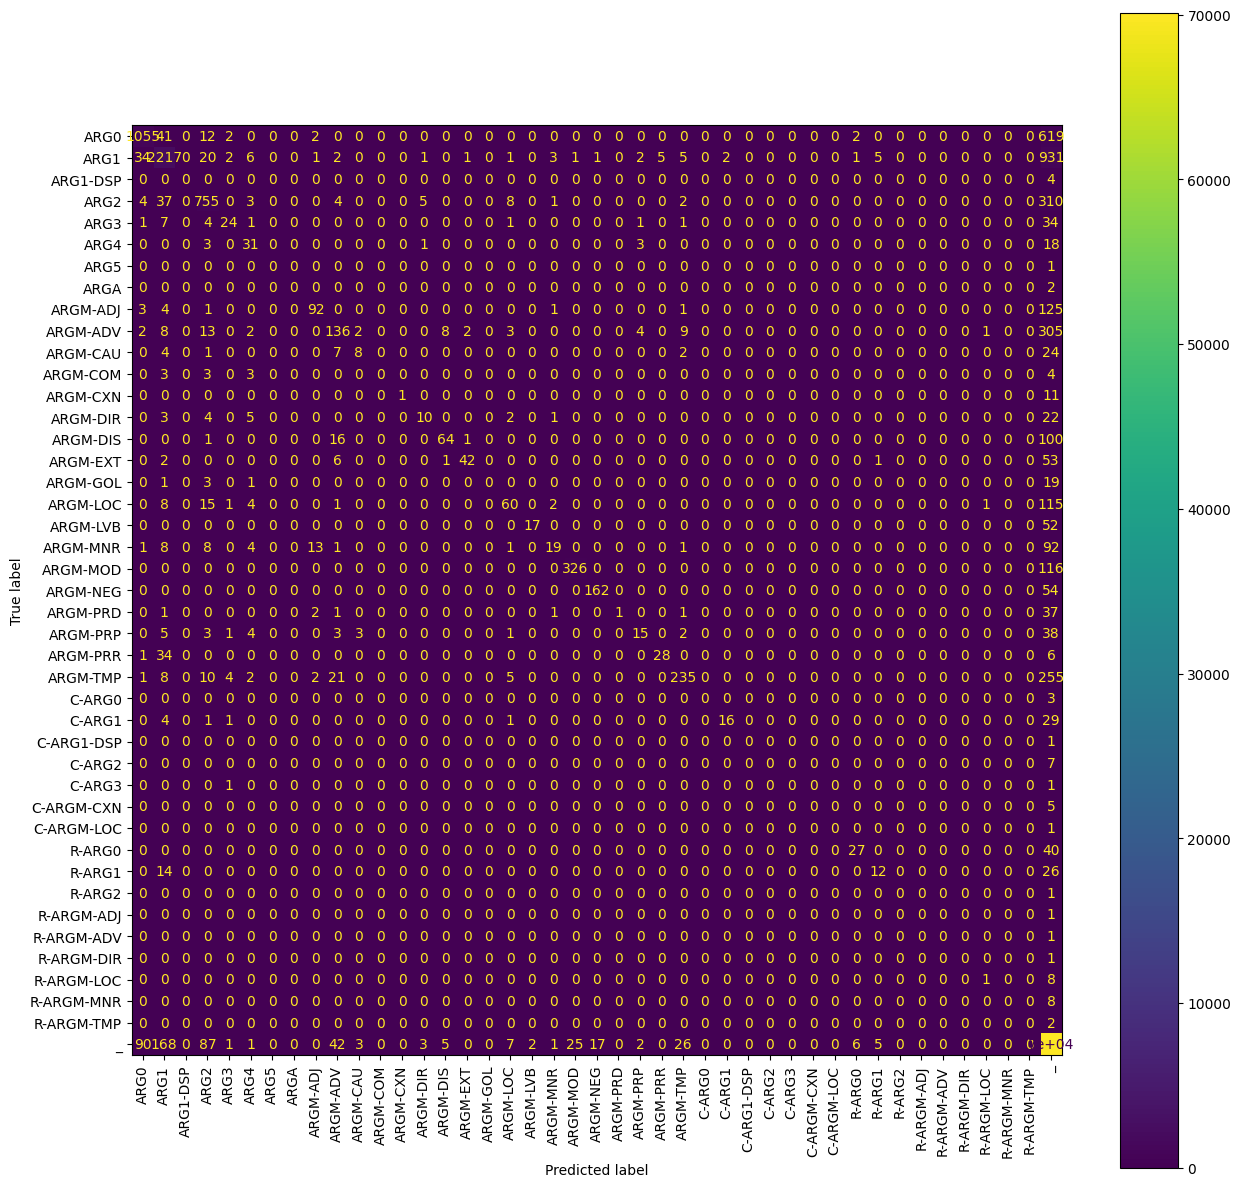

Evaluation report saved to: evaluation_report_2024-10-10_11-55-55.json


In [23]:
# Create a set of labels in alphabetical order.
label_set_test = sorted(set(gold_labels_test))

# Create a classification report and confusion matrix
report_dict_test, report_test, label_set_test = create_classification_report(gold_labels_test, predictions_test, label_set_test)
cf_matrix_test = plot_confusion_matrix(gold_labels_test, predictions_test, label_set_test)

# Save the evaluation report of the test data to a JSON file
save_evaluation_report(report_dict_test, cf_matrix_test)

The evaluation report of the test data is saved to a JSON file.

The logistic regression model achieves a macro-average F1 score of **0.287** on the test dataset with an overall accuracy of **0.943** (94.3% of all predictions are correct). 

_Note that macro-average F1 scores are unweighted and impacted by the presence of many rare labels with low precision and recall scores._

#### 